# GitHub Commit Analysis: Italy's ChatGPT Ban Impact

## Research Question
Did Italy's temporary ban on ChatGPT (April 1-28, 2023) affect software development activity as measured by GitHub commits?

## Experimental Design
- **Treatment Group**: Italy (ChatGPT banned April 1-28, 2023)
- **Control Groups**: Austria and France (no ChatGPT restrictions)
- **Analysis Period**: 60 days before and after March 27, 2023
- **Key Dates**: 
  - April 1, 2023: ChatGPT ban implemented in Italy
  - April 28, 2023: ChatGPT ban lifted in Italy

## Data Sources
- GitHub Archive BigQuery dataset
- Individual commit events from 1000 developers in Italy, Austria, and France
- Time period: January 26, 2023 to May 26, 2023

## Sample Size
- **Italy**: 1000 developers (treatment group)
- **Austria**: 1000 developers (control group)  
- **France**: 1000 developers (control group)
- **Total**: 3000 developers for robust statistical analysis

## Ban Duration Analysis
This analysis allows experimentation with different ban durations:
- **Full ban**: April 1-28, 2023 (28 days)
- **First 7 days**: April 1-7, 2023 (7 days) - accounts for adaptation period
- **First 3 days**: April 1-3, 2023 (3 days) - immediate impact only


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set figure size for better readability
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("📊 Analysis Setup Complete")
print("Sample size: 1000 developers per country (3000 total)")
print("Analysis period: January 26 - May 26, 2023")
print("Ban duration: Configurable (7 days, 3 days, or full 28 days)")


📊 Analysis Setup Complete
Sample size: 1000 developers per country (3000 total)
Analysis period: January 26 - May 26, 2023
Ban duration: Configurable (7 days, 3 days, or full 28 days)


## Data Loading and Preprocessing

**Note**: Make sure to run the data collection script first with 1000 users per country:

```bash
# Collect data for Italy (1000 users)
python ../gh-archive-bigquery/fetch_commit_events.py ../github_scrape/data/github_users_merged_italy.csv --sample 1000

# Collect data for Austria (1000 users)  
python ../gh-archive-bigquery/fetch_commit_events.py ../github_scrape/data/github_users_merged_austria.csv --sample 1000

# Collect data for France (1000 users)
python ../gh-archive-bigquery/fetch_commit_events.py ../github_scrape/data/github_users_merged_france.csv --sample 1000
```


In [32]:
# Load commit data for all three countries (1000 users each)
italy_commits = pd.read_csv('../gh-archive-bigquery/output/github_users_merged_italy_commit_events.csv')
austria_commits = pd.read_csv('../gh-archive-bigquery/output/github_users_merged_austria_commit_events.csv')
france_commits = pd.read_csv('../gh-archive-bigquery/output/github_users_merged_france_commit_events.csv')

# Load user data to get total user counts for normalization
italy_users = pd.read_csv('../gh-archive-bigquery/output/github_users_merged_italy_users_sample.csv')
austria_users = pd.read_csv('../gh-archive-bigquery/output/github_users_merged_austria_users_sample.csv')
france_users = pd.read_csv('../gh-archive-bigquery/output/github_users_merged_france_users_sample.csv')

print(f"📈 Data Summary:")
print(f"Italy: {len(italy_commits)} commits from {len(italy_users)} users")
print(f"Austria: {len(austria_commits)} commits from {len(austria_users)} users")
print(f"France: {len(france_commits)} commits from {len(france_users)} users")
print(f"Total commits: {len(italy_commits) + len(austria_commits) + len(france_commits)}")
print(f"Total users: {len(italy_users) + len(austria_users) + len(france_users)}")


📈 Data Summary:
Italy: 16130 commits from 1000 users
Austria: 21096 commits from 1000 users
France: 20977 commits from 1000 users
Total commits: 58203
Total users: 3000


In [33]:
# Add country labels and combine datasets
italy_commits['country'] = 'Italy'
austria_commits['country'] = 'Austria'
france_commits['country'] = 'France'

# Combine all commit data
all_commits = pd.concat([italy_commits, austria_commits, france_commits], ignore_index=True)

# Convert event_timestamp to datetime
all_commits['event_timestamp'] = pd.to_datetime(all_commits['event_timestamp'])
all_commits['date'] = all_commits['event_timestamp'].dt.date

print(f"📅 Combined Dataset:")
print(f"Total commits: {len(all_commits)}")
print(f"Date range: {all_commits['date'].min()} to {all_commits['date'].max()}")
print(f"Countries: {all_commits['country'].unique()}")
print(f"Unique users: {all_commits['username'].nunique()}")


📅 Combined Dataset:
Total commits: 58203
Date range: 2023-01-26 to 2023-05-26
Countries: ['Italy' 'Austria' 'France']
Unique users: 814


## Configurable Ban Duration Analysis

**Key Insight**: People likely adapted to the ban after a few days (using VPNs, etc.), so we should focus on the immediate impact period.


In [34]:
# Define key dates
ban_start = datetime(2023, 4, 1).date()
ban_end_full = datetime(2023, 4, 28).date()  # Full ban period
ban_end_7days = datetime(2023, 4, 7).date()   # First 7 days only
ban_end_3days = datetime(2023, 4, 3).date()    # First 3 days only
target_date = datetime(2023, 3, 27).date()  # Center of our analysis period

print(f"🗓️ Key Dates:")
print(f"Full ChatGPT ban period: {ban_start} to {ban_end_full}")
print(f"First 7 days of ban: {ban_start} to {ban_end_7days}")
print(f"First 3 days of ban: {ban_start} to {ban_end_3days}")
print(f"Analysis center date: {target_date}")

# Define analysis periods
pre_ban_start = datetime(2023, 1, 26).date()
pre_ban_end = datetime(2023, 3, 31).date()
post_ban_start = datetime(2023, 4, 29).date()
post_ban_end = datetime(2023, 5, 26).date()

print(f"\n📊 Analysis Periods:")
print(f"Pre-ban period: {pre_ban_start} to {pre_ban_end} ({pre_ban_end - pre_ban_start} days)")
print(f"Ban period (3 days): {ban_start} to {ban_end_3days} ({ban_end_3days - ban_start} days)")
print(f"Ban period (7 days): {ban_start} to {ban_end_7days} ({ban_end_7days - ban_start} days)")
print(f"Ban period (full): {ban_start} to {ban_end_full} ({ban_end_full - ban_start} days)")
print(f"Post-ban period: {post_ban_start} to {post_ban_end} ({post_ban_end - post_ban_start} days)")

# Set the ban period to analyze (can be changed)
BAN_PERIOD = "7days"  # Options: "3days", "7days", "full"
if BAN_PERIOD == "3days":
    ban_end = ban_end_3days
    print(f"\n🎯 Using 3-day ban period for analysis (immediate impact)")
elif BAN_PERIOD == "7days":
    ban_end = ban_end_7days
    print(f"\n🎯 Using 7-day ban period for analysis (before adaptation)")
else:
    ban_end = ban_end_full
    print(f"\n🎯 Using full ban period for analysis (includes adaptation period)")

print(f"\n📈 Selected ban period: {ban_start} to {ban_end} ({(ban_end - ban_start).days} days)")


🗓️ Key Dates:
Full ChatGPT ban period: 2023-04-01 to 2023-04-28
First 7 days of ban: 2023-04-01 to 2023-04-07
First 3 days of ban: 2023-04-01 to 2023-04-03
Analysis center date: 2023-03-27

📊 Analysis Periods:
Pre-ban period: 2023-01-26 to 2023-03-31 (64 days, 0:00:00 days)
Ban period (3 days): 2023-04-01 to 2023-04-03 (2 days, 0:00:00 days)
Ban period (7 days): 2023-04-01 to 2023-04-07 (6 days, 0:00:00 days)
Ban period (full): 2023-04-01 to 2023-04-28 (27 days, 0:00:00 days)
Post-ban period: 2023-04-29 to 2023-05-26 (27 days, 0:00:00 days)

🎯 Using 7-day ban period for analysis (before adaptation)

📈 Selected ban period: 2023-04-01 to 2023-04-07 (6 days)


In [ ]:
## Comparison of Different Ban Durations

# Calculate daily commit counts by country
daily_commits = all_commits.groupby(['date', 'country']).size().reset_index(name='commit_count')

# Pivot to have countries as columns
daily_commits_pivot = daily_commits.pivot(index='date', columns='country', values='commit_count').fillna(0)

# Convert index to datetime for better plotting
daily_commits_pivot.index = pd.to_datetime(daily_commits_pivot.index)

# Calculate total users per country (should be 1000 each)
user_counts = {
    'Italy': len(italy_users),
    'Austria': len(austria_users),
    'France': len(france_users)
}

# Calculate commits per user per day
daily_commits_normalized = daily_commits_pivot.copy()
for country in daily_commits_normalized.columns:
    daily_commits_normalized[country] = daily_commits_normalized[country] / user_counts[country]

print("📈 Daily commit counts by country (first 10 days):")
print(daily_commits_pivot.head(10))

print(f"\n📊 Summary statistics:")
for country in daily_commits_normalized.columns:
    print(f"{country}: Mean={daily_commits_normalized[country].mean():.4f}, Max={daily_commits_normalized[country].max():.4f}")


📈 Daily commit counts by country (first 10 days):
country     Austria  France  Italy
date                              
2023-01-26      169     224     72
2023-01-27      203     160    141
2023-01-28      229     193     27
2023-01-29      194     192    116
2023-01-30      287     268    118
2023-01-31      306     196     83
2023-02-01      214     159    132
2023-02-02      267     151    112
2023-02-03      238     197    158
2023-02-04      170      89    100

📊 Summary statistics:
Austria: Mean=0.1743, Max=0.4410
France: Mean=0.1734, Max=0.4830
Italy: Mean=0.1333, Max=0.6690


In [36]:
# Function to calculate period statistics
def calculate_period_stats(df, start_date, end_date, user_counts):
    period_data = df[(df.index.date >= start_date) & (df.index.date <= end_date)]
    stats = {}
    for country in df.columns:
        raw_avg = period_data[country].mean()
        normalized_avg = raw_avg / user_counts[country]
        stats[country] = {
            'raw_avg': raw_avg,
            'normalized_avg': normalized_avg,
            'total_commits': period_data[country].sum(),
            'days': len(period_data)
        }
    return stats

# Calculate statistics for different ban durations
def calculate_did(treatment_country, control_countries, pre_stats, ban_stats):
    treatment_pre = pre_stats[treatment_country]['normalized_avg']
    treatment_during = ban_stats[treatment_country]['normalized_avg']
    treatment_change = treatment_during - treatment_pre
    
    control_pre = np.mean([pre_stats[country]['normalized_avg'] for country in control_countries])
    control_during = np.mean([ban_stats[country]['normalized_avg'] for country in control_countries])
    control_change = control_during - control_pre
    
    did = treatment_change - control_change
    
    return {
        'treatment_change': treatment_change,
        'control_change': control_change,
        'did_estimate': did,
        'treatment_pre': treatment_pre,
        'treatment_during': treatment_during,
        'control_pre': control_pre,
        'control_during': control_during
    }

# Calculate pre-ban statistics
pre_ban_stats = calculate_period_stats(daily_commits_pivot, pre_ban_start, pre_ban_end, user_counts)

# Calculate statistics for different ban durations
ban_3days_stats = calculate_period_stats(daily_commits_pivot, ban_start, ban_end_3days, user_counts)
ban_7days_stats = calculate_period_stats(daily_commits_pivot, ban_start, ban_end_7days, user_counts)
ban_full_stats = calculate_period_stats(daily_commits_pivot, ban_start, ban_end_full, user_counts)

# Calculate DiD for each duration
did_3days = calculate_did('Italy', ['Austria', 'France'], pre_ban_stats, ban_3days_stats)
did_7days = calculate_did('Italy', ['Austria', 'France'], pre_ban_stats, ban_7days_stats)
did_full = calculate_did('Italy', ['Austria', 'France'], pre_ban_stats, ban_full_stats)

print("🔬 Difference-in-Differences Comparison:")
print(f"3-day ban:  {did_3days['did_estimate']:.6f} commits/user/day")
print(f"7-day ban:  {did_7days['did_estimate']:.6f} commits/user/day")
print(f"Full ban:   {did_full['did_estimate']:.6f} commits/user/day")

print(f"\n📊 Effect Magnitude Comparison:")
for duration, did_result in [("3-day", did_3days), ("7-day", did_7days), ("Full", did_full)]:
    effect = abs(did_result['did_estimate'])
    if effect < 0.001:
        magnitude = "minimal"
    elif effect < 0.005:
        magnitude = "small"
    elif effect < 0.01:
        magnitude = "moderate"
    else:
        magnitude = "large"
    print(f"{duration:>8}: {magnitude} effect ({effect:.6f})")


🔬 Difference-in-Differences Comparison:
3-day ban:  0.017315 commits/user/day
7-day ban:  0.011315 commits/user/day
Full ban:   0.005726 commits/user/day

📊 Effect Magnitude Comparison:
   3-day: large effect (0.017315)
   7-day: large effect (0.011315)
    Full: moderate effect (0.005726)


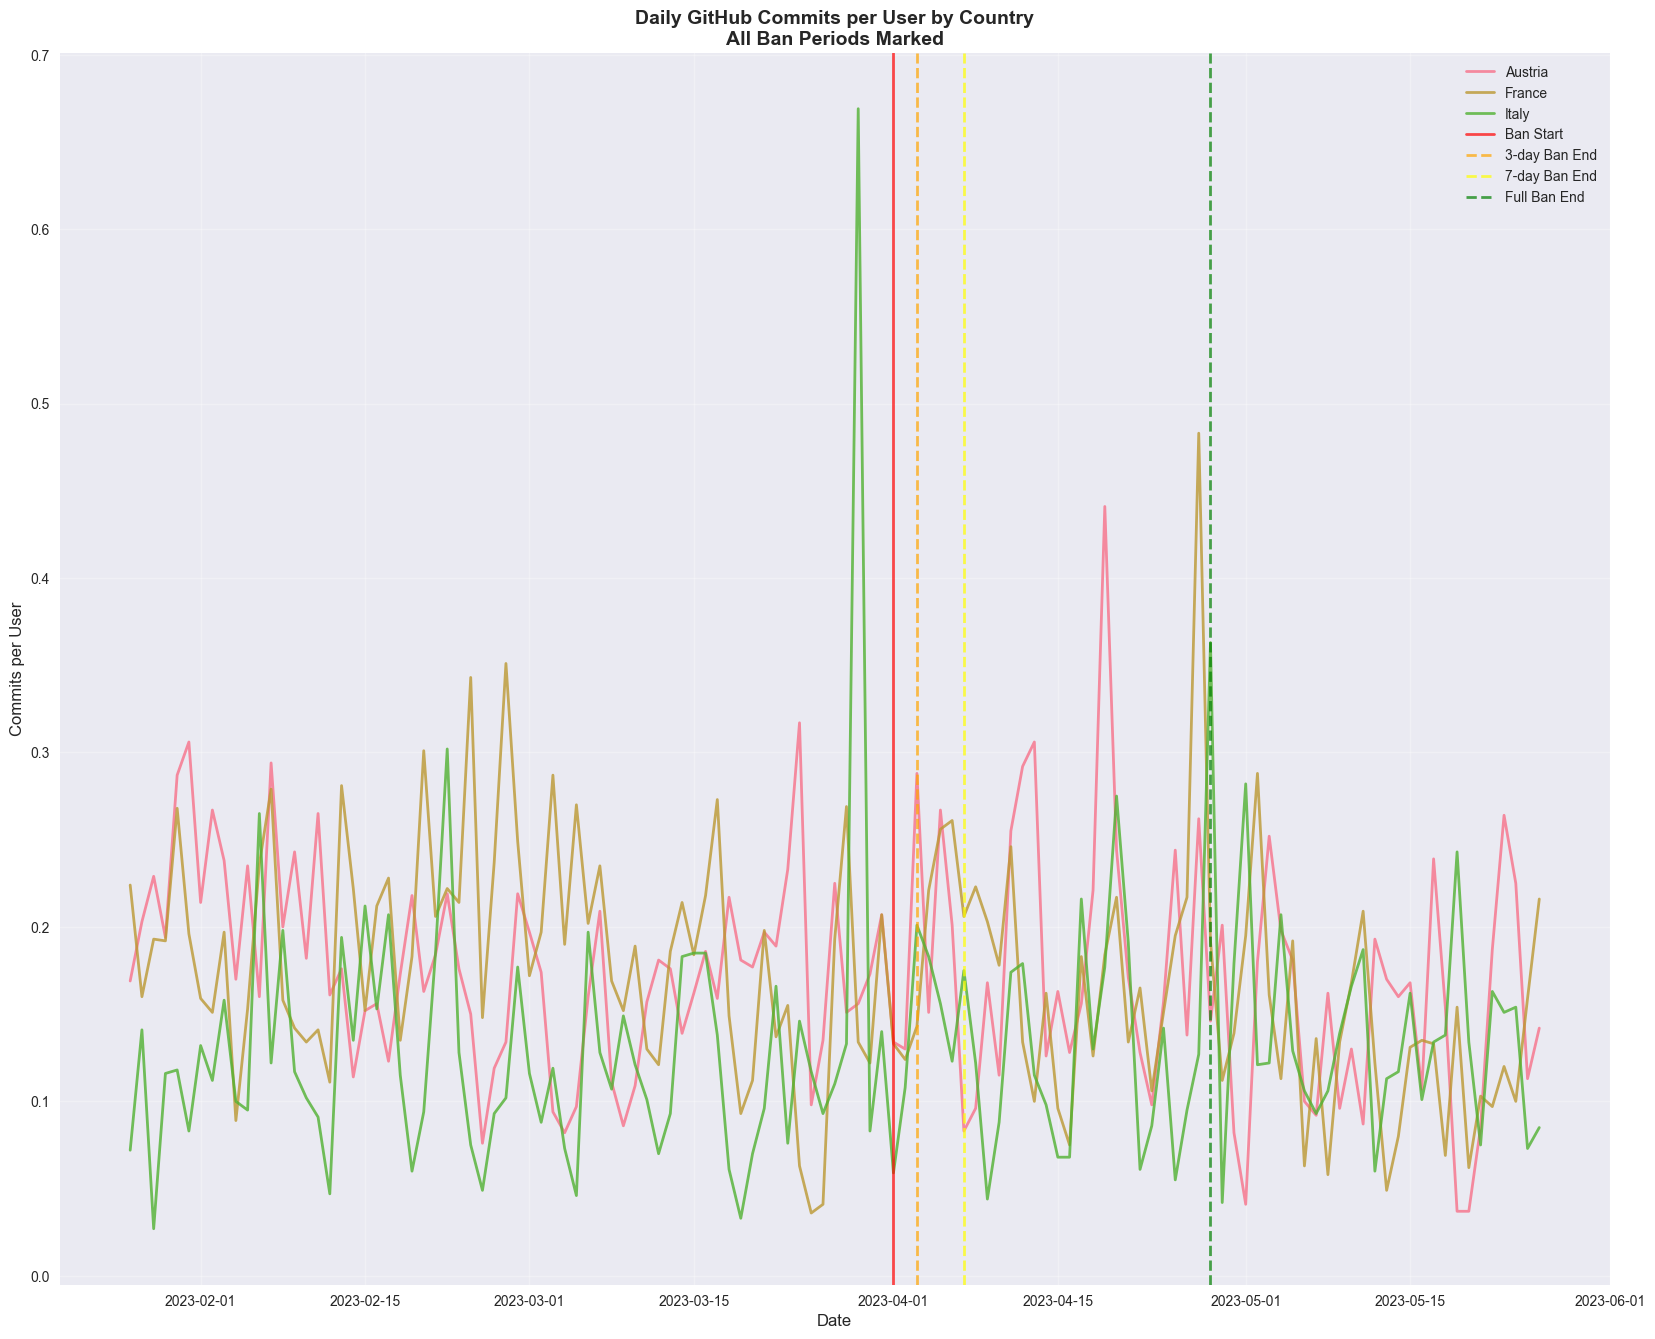

In [ ]:
## Visualization: Ban Duration Comparison
# Create comparison visualization
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 16))

# Plot 1: Daily trends with all ban periods marked
for country in daily_commits_normalized.columns:
    ax1.plot(daily_commits_normalized.index, daily_commits_normalized[country], 
             label=country, linewidth=2, alpha=0.8)

# Add vertical lines for different ban periods
ax1.axvline(x=ban_start, color='red', linestyle='-', alpha=0.7, linewidth=2, label='Ban Start')
ax1.axvline(x=ban_end_3days, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='3-day Ban End')
ax1.axvline(x=ban_end_7days, color='yellow', linestyle='--', alpha=0.7, linewidth=2, label='7-day Ban End')
ax1.axvline(x=ban_end_full, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Full Ban End')

ax1.set_title('Daily GitHub Commits per User by Country\nAll Ban Periods Marked', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Commits per User', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

## Detailed Analysis for Selected Ban Duration

Now let's perform detailed analysis using the selected ban duration.


In [38]:
# Use the selected ban duration for detailed analysis
if BAN_PERIOD == "3days":
    ban_stats = ban_3days_stats
    did_results = did_3days
    selected_duration = "3-day"
elif BAN_PERIOD == "7days":
    ban_stats = ban_7days_stats
    did_results = did_7days
    selected_duration = "7-day"
else:
    ban_stats = ban_full_stats
    did_results = did_full
    selected_duration = "full"

print(f"🎯 Detailed Analysis for {selected_duration} ban period:")
print(f"Ban period: {ban_start} to {ban_end} ({(ban_end - ban_start).days} days)")

# Create summary table
summary_data = []
for country in ['Italy', 'Austria', 'France']:
    summary_data.append({
        'Country': country,
        'Pre-Ban (avg/day)': f"{pre_ban_stats[country]['normalized_avg']:.4f}",
        f'During {selected_duration} Ban (avg/day)': f"{ban_stats[country]['normalized_avg']:.4f}",
        'Pre-Ban Total': pre_ban_stats[country]['total_commits'],
        f'During {selected_duration} Ban Total': ban_stats[country]['total_commits']
    })

summary_df = pd.DataFrame(summary_data)
print(f"\n📊 Summary Statistics (Commits per User per Day):")
print(summary_df.to_string(index=False))

print(f"\n🔬 Difference-in-Differences Results:")
print(f"Italy (Treatment) Change: {did_results['treatment_change']:.6f} commits/user/day")
print(f"Austria+France (Control) Change: {did_results['control_change']:.6f} commits/user/day")
print(f"Difference-in-Differences Estimate: {did_results['did_estimate']:.6f} commits/user/day")
print(f"\n💡 Interpretation: The ChatGPT ban {'reduced' if did_results['did_estimate'] < 0 else 'increased'} ")
print(f"development activity in Italy by {abs(did_results['did_estimate']):.6f} commits per user per day ")
print(f"relative to the control countries during the {selected_duration} period.")


🎯 Detailed Analysis for 7-day ban period:
Ban period: 2023-04-01 to 2023-04-07 (6 days)

📊 Summary Statistics (Commits per User per Day):
Country Pre-Ban (avg/day) During 7-day Ban (avg/day)  Pre-Ban Total  During 7-day Ban Total
  Italy            0.1303                     0.1436           8469                    1005
Austria            0.1801                     0.1791          11704                    1254
 France            0.1872                     0.1920          12165                    1344

🔬 Difference-in-Differences Results:
Italy (Treatment) Change: 0.013279 commits/user/day
Austria+France (Control) Change: 0.001964 commits/user/day
Difference-in-Differences Estimate: 0.011315 commits/user/day

💡 Interpretation: The ChatGPT ban increased 
development activity in Italy by 0.011315 commits per user per day 
relative to the control countries during the 7-day period.
